# Project - First Requirement

### Include packages.

In [205]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm    # Just to plot distribution of valuations
from scipy import optimize

### The first thing to do is to code the environment.

In [206]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

### In this setting, the environment is responsible for telling the seller about the reward.

In [207]:
class PricingEnvironmentSingleProduct(Environment):
    def __init__(self, cost, mean_valuation, std_valuation, buyers_per_round):
        self.cost = cost
        self.mean_valuation = mean_valuation
        self.std_valuation = std_valuation
        self.buyers_per_round = buyers_per_round

    def round(self, p_t):
        # Probability of a single customer buying at price p_t
        prob_buy = 1 - norm.cdf(p_t, loc=self.mean_valuation, scale=self.std_valuation)

        # Number of sales is drawn from a binomial distribution
        num_of_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)
        reward = (p_t - self.cost) * num_of_sales
        
        return num_of_sales, reward

### Now define the setting...

In [208]:
# --- Global Settings ---

np.random.seed(30)

T = 10000                   # Time horizon (number of rounds)
n_trials = 10               # Number of independent trials for averaging
N = 1                       # Number of products (unused in this version)

# --- Pricing Grid and Product Info ---

min_p = 0.0
max_p = 5.0
price_step = 0.5
P = np.linspace(min_p, max_p, int((max_p - min_p) / price_step) + 1)    # Discrete set of prices
K = len(P)                                                              # Number of price options (arms)

cost = 2.00                                                             # Unit production cost
value = 3.00                                                            # True mean customer valuation
std_valuation = 1.0                                                     # Standard deviation of customer valuations

assert cost < value, "Cost must be less than value"

# --- Market and Inventory Parameters ---

buyers_per_round = 50
assert buyers_per_round >= 1, "Must have at least one buyer per round"

B = 120000                              # Total inventory available (seller capacity)
R = (max(P)-cost) * buyers_per_round    # Range for the UCB1 agent is the maximum possible reward in a round, which is given by:

zoom = 0.05     # Zoom factor for plotting the valuation distribution       


### Expected demand and profit using theoretical expectations.

In [209]:
# In our setting, customer valuations are drawn from a normal distribution.
# Given this assumption, we can analytically compute the expected demand at each price p.
# It can be proven that the expected demand is given by:

def expected_demand(p, mean_valuation, std_valuation, buyers_per_round):
    # Probability of a single customer buying
    prob_buy = 1 - norm.cdf(p, loc=mean_valuation, scale=std_valuation)
    # Expected number of buyers
    return buyers_per_round * prob_buy

expected_demand_vector = np.array([expected_demand(p, value, std_valuation, buyers_per_round) for p in P])
expected_profit_vector = (P - cost) * expected_demand_vector

best_expected_index = np.argmax(expected_profit_vector)
best_expected_price = P[best_expected_index]
best_expected_profit = expected_profit_vector[best_expected_index]

### Let us visualize our setting.

Max expected profit (theoretical): 25.0
...at price: 3.0


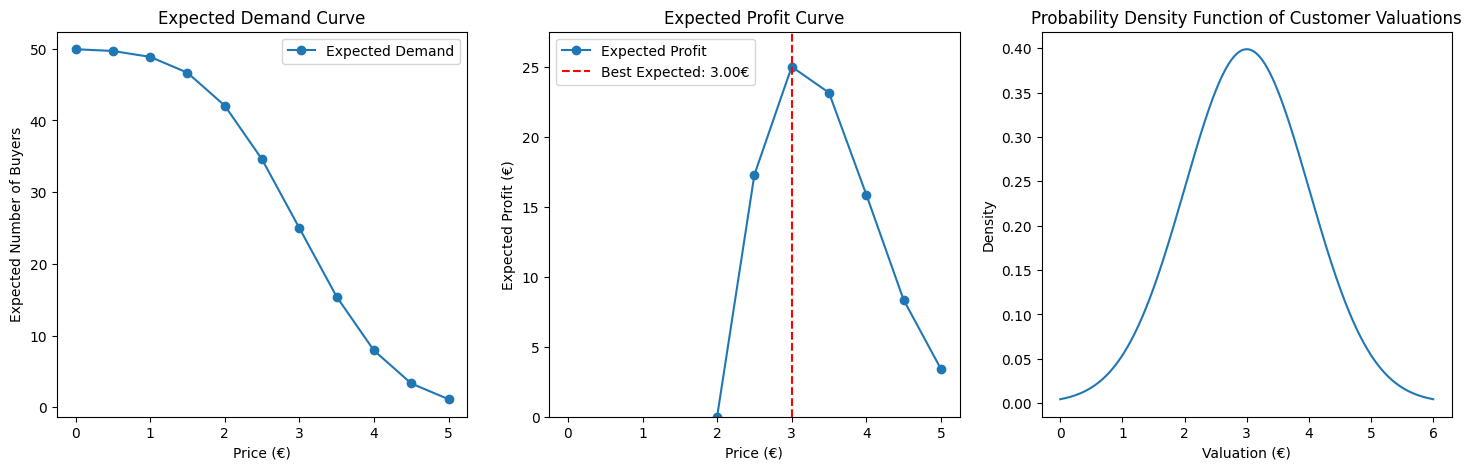

In [210]:
# --- Summary of Results ---

print("Max expected profit (theoretical):", round(best_expected_profit, 2))
print("...at price:", round(best_expected_price, 2))

# --- Plots: Expected Demand and Profit, and PDF of Valuations ---

# Create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5)) # Increased figsize for better visibility

# Demand curve (expected)
axs[0].plot(P, expected_demand_vector, label='Expected Demand', marker='o')
axs[0].set_title("Expected Demand Curve")
axs[0].set_xlabel("Price (€)")
axs[0].set_ylabel("Expected Number of Buyers")
axs[0].legend()

# Profit curve (expected)
axs[1].plot(P, expected_profit_vector, label='Expected Profit', marker='o')
axs[1].axvline(best_expected_price, color='r', linestyle='--', label=f"Best Expected: {best_expected_price:.2f}€")
axs[1].set_title("Expected Profit Curve")
axs[1].set_xlabel("Price (€)")
axs[1].set_ylabel("Expected Profit (€)")
axs[1].legend()

# Adjust y-axis for profit to show just above the lowest observed positive profit
positive_profits = expected_profit_vector
ymin = max(min(positive_profits[positive_profits > 0].min(), 0), 0)
ymax = positive_profits.max() * 1.1  # a bit of margin on top
axs[1].set_ylim(ymin, ymax)

# Plot for the PDF of customer valuations (now in the third subplot)
x_vals = np.linspace(min_p, max_p * 1.2, 500) # Extend range slightly for visualization
axs[2].plot(x_vals, norm.pdf(x_vals, loc=value, scale=std_valuation))
axs[2].set_title("Probability Density Function of Customer Valuations")
axs[2].set_xlabel("Valuation (€)")
_ = axs[2].set_ylabel("Density")

### How can I interact with this environment? We use Agents.

In [211]:
class Agent:
    def __init__(self):
        pass
    def pull_arm(self):
        pass
    def update(self, r_t):
        pass

### Define the UCB1 Agent.

In [212]:
# If rewards lie in [0, R], you must scale the confidence term by self.range = R maximum possible reward in a round t.

class UCB1Agent(Agent):
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        if self.t < self.K: # In the first K rounds, we sample each arm once
            self.a_t = self.t
        else:   
            ucbs = self.average_rewards + self.range * np.sqrt( 2 * np.log(self.T) / self.N_pulls )
            self.a_t = np.argmax(ucbs)
        return self.a_t

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += ( r_t - self.average_rewards[self.a_t] ) / self.N_pulls[self.a_t]
        self.t += 1

### E.g. Instantaneous Regret - Single run.

Set up environment and agent.

In [213]:
# Initialize the stochastic environment
env = PricingEnvironmentSingleProduct(cost=cost, mean_valuation=value, std_valuation=std_valuation, buyers_per_round=buyers_per_round)

Expected best price (clairvoyant): 3.0


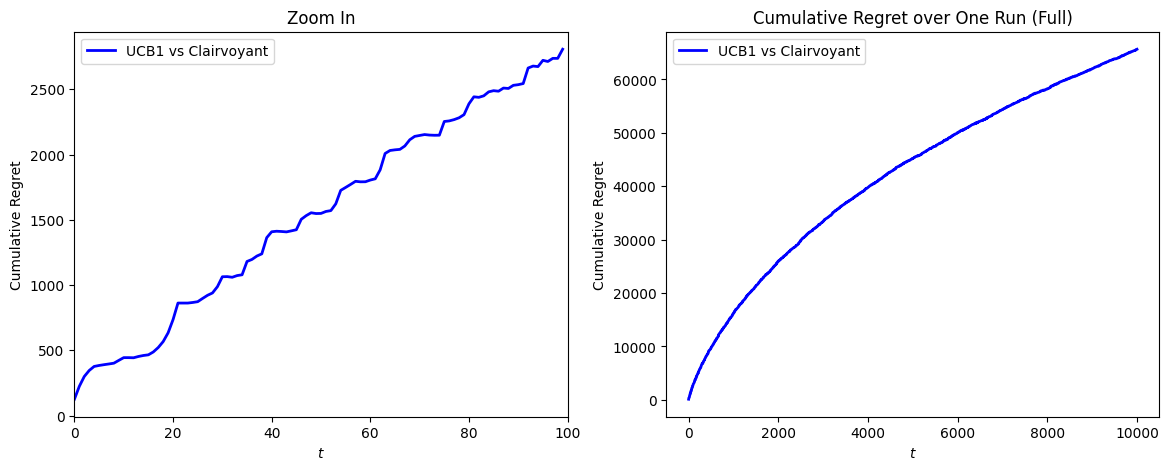

In [214]:
# --- Single run to compare realized rewards ---

# Compute clairvoyant rewards
clairvoyant_expected_rewards = np.array([env.round(P[best_expected_index])[1] for _ in range(T)])

# Run UCB1
ucb_agent = UCB1Agent(K, T, range=R)
agent_rewards = np.array([])
pull_counts = np.zeros(K, dtype=int)  # <-- Track number of times each arm is pulled
for t in range(T):
    pi_t = ucb_agent.pull_arm()
    p_t = P[pi_t]
    d_t, r_t = env.round(p_t)
    ucb_agent.update(r_t)
    agent_rewards = np.append(agent_rewards, r_t)
    pull_counts[pi_t] += 1

# Compute most played price
most_played_action = np.argmax(pull_counts)
most_played_price = P[most_played_action]

# Compute regret
expected_regret = np.cumsum(clairvoyant_expected_rewards - agent_rewards)
print("Expected best price (clairvoyant):", round(best_expected_price, 2))

# --- Plots ---

zoom_T = int(T * 0.01)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

# Zoom
ax1.plot(np.arange(zoom_T), expected_regret[:zoom_T], 'b-', linewidth=2, label='UCB1 vs Clairvoyant')
ax1.set_xlim(0, zoom_T)
ax1.set_title('Zoom In')
ax1.set_xlabel('$t$')
ax1.set_ylabel('Cumulative Regret')
ax1.legend()

# Full
ax2.plot(np.arange(T), expected_regret, 'b-', linewidth=2, label='UCB1 vs Clairvoyant')
ax2.set_title('Cumulative Regret over One Run (Full)')
ax2.set_xlabel('$t$')
ax2.set_ylabel('Cumulative Regret')
_ = ax2.legend()

### Let's see in which arms the algorithm spent more time.

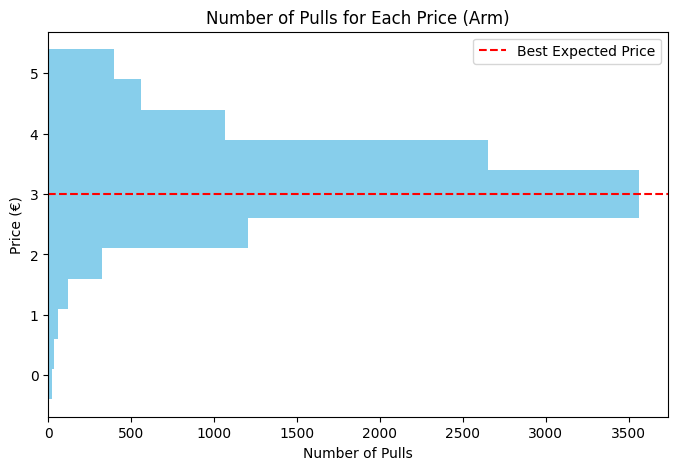

In [215]:
# --- UCB1 Agent Pull Counts ---
plt.figure(figsize=(8, 5))

# Use P for y-axis to show prices, and N_pulls for x-axis (number of pulls)
plt.barh(P, ucb_agent.N_pulls, color='skyblue')
plt.axhline(P[best_expected_index], color='red', linestyle='--', label='Best Expected Price')
plt.xlabel('Number of Pulls')
plt.ylabel('Price (€)')
plt.title('Number of Pulls for Each Price (Arm)')
plt.legend()
plt.show()

### Pseudo Regret - Estimation


Since it is very complex to compute the theoretical Expected Regret (nor Pseudo) at each round - due to the complex stochasticity in the choice of the action... We estimate it by computing it as the average cumulative regret per round, over many trials. To do this, we use the expected reward of both the clairvoyant and the agent actions, to reduce the variability of the estimation.

Average regret after 10 trials: 66373.20


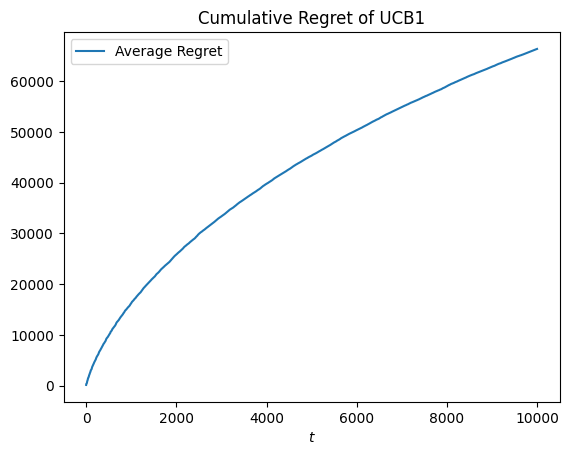

In [216]:
# --- Compute cumulative regret over multiple trials ---
regret_per_trial = []
expected_clairvoyant_rewards = np.repeat(best_expected_profit, T)

for seed in range(n_trials):
    np.random.seed(seed) # Keep seed for reproducibility of each trial's sequence
    env = PricingEnvironmentSingleProduct(cost=cost, mean_valuation=value, std_valuation=std_valuation, buyers_per_round=buyers_per_round)

    ucb_agent = UCB1Agent(K, T, range=R)
    agent_rewards = np.array([])

    for t in range(T):
        pi_t = ucb_agent.pull_arm()
        p_t = P[pi_t]
        d_t, r_t = env.round(p_t)
        ucb_agent.update(r_t)
        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards - agent_rewards)
    regret_per_trial.append(cumulative_regret)

average_regret = np.array(regret_per_trial).mean(axis=0)

print("Average regret after {} trials: {:.2f}".format(n_trials, average_regret[-1]))

# Plot cumulative regret
plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('Cumulative Regret of UCB1')
plt.xlabel('$t$')
_ = plt.legend()

### Let's introduce a maximum capacity for the seller: UCB-LIKE AGENT.

In [217]:
# --- Agent ---
class UCBLikeInventoryAgent():
    def __init__(self, K, B, T, range=1):
        self.K = K                      # Number of prices
        self.T = T                      # Horizon
        self.range = range              # Confidence scaling factor
        self.a_t = None                 # Last chosen arm index
        self.avg_f = np.zeros(K)        # Average reward per arm
        self.avg_c = np.zeros(K)        # Average consumption per arm
        self.N_pulls = np.zeros(K)      # Number of pulls per arm
        self.inventory = B              # Total inventory (instead of budget)
        self.rho = B / T                # Average allowed consumption per round
        self.t = 0                      # Current round

    def pull_arm(self, return_gamma=False):
        if self.inventory < 1:
            self.a_t = None
            return (None, None) if return_gamma else None

        if self.t < self.K:
            self.a_t = self.t
            gamma = np.zeros(self.K)
            gamma[self.a_t] = 1.0
        else:
            f_ucbs = self.avg_f + self.range * np.sqrt(2 * np.log(self.T) / self.N_pulls)
            c_lcbs = self.avg_c - self.range * np.sqrt(2 * np.log(self.T) / self.N_pulls)
            gamma = self.compute_opt(f_ucbs, c_lcbs)
            self.a_t = np.random.choice(self.K, p=gamma)

        return (self.a_t, gamma) if return_gamma else self.a_t

    def compute_opt(self, f_ucbs, c_lcbs):
        # If all LCBs are zero or negative, fallback to greedy
        if np.sum(c_lcbs <= np.zeros(self.K)) == self.K:
            gamma = np.zeros(self.K)
            gamma[np.argmax(f_ucbs)] = 1
            return gamma
        
        # Solve the linear program
        c = -f_ucbs
        A_ub = [c_lcbs]
        b_ub = [self.rho]
        A_eq = [np.ones(self.K)]
        b_eq = [1]
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1), method='highs')
        gamma = res.x
        return gamma

    def update(self, f_t, c_t):
        self.N_pulls[self.a_t] += 1
        self.avg_f[self.a_t] += (f_t - self.avg_f[self.a_t]) / self.N_pulls[self.a_t]
        self.avg_c[self.a_t] += (c_t - self.avg_c[self.a_t]) / self.N_pulls[self.a_t]
        self.inventory -= c_t
        self.t += 1

### Compute the regret for our new algorithm.

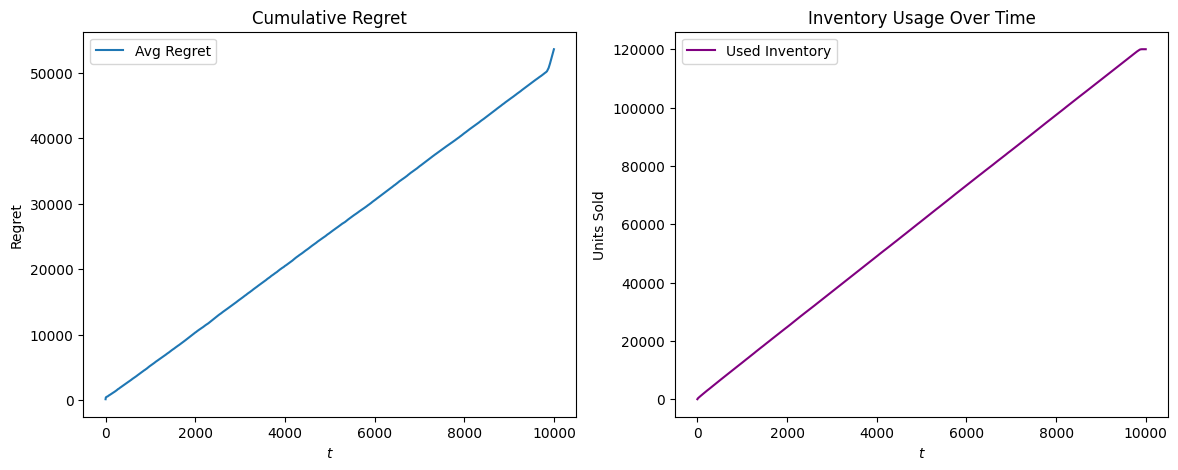

In [ ]:
# Compute cumulative regret over multiple trials
regret_per_trial = []
inventory_per_trial = []
expected_clairvoyant_rewards = np.repeat(best_expected_profit, T)

for seed in range(n_trials):
    np.random.seed(seed)    # Keep seed for reproducibility of each trial's sequence

    # To visualize the chosen arms on the last trial
    if seed == n_trials - 1:
        actions_in_time = []
        gamma_best_trace = []
    
    # Create environment
    env = PricingEnvironmentSingleProduct(cost=cost, mean_valuation=value, std_valuation=std_valuation, buyers_per_round=buyers_per_round)
    
    # Initialize
    ucb_like_agent = UCBLikeInventoryAgent(K=K, B=B, T=T, range=1)
    agent_rewards = []
    inventory_trace = []

    # Run UCB1 for T rounds
    for t in range(T):

        # If it's the last trial, we want to see the gamma
        if seed == n_trials - 1:
            pi_t, gamma = ucb_like_agent.pull_arm(return_gamma=True)
        else:
            pi_t = ucb_like_agent.pull_arm()
    
        # If the inventory is exhausted, break the loop
        if pi_t is None:
            agent_rewards.extend([0] * (T - t))
            inventory_trace.extend([ucb_like_agent.inventory] * (T - t))
            break

        # To visualize the chosen arms on the last trial
        if seed == n_trials - 1:
            actions_in_time.append(P[pi_t])
            gamma_best_trace.append(gamma[best_expected_index])

        # Otherwise, proceed 
        p_t = P[pi_t]
        d_t, r_t = env.round(p_t)
        ucb_like_agent.update(f_t=r_t, c_t=d_t)
        agent_rewards.append(r_t)
        inventory_trace.append(ucb_like_agent.inventory)

    # Store cumulative regret for this trial
    cumulative_regret = np.cumsum(expected_clairvoyant_rewards - np.array(agent_rewards))
    regret_per_trial.append(cumulative_regret)
    inventory_per_trial.append(inventory_trace)

# --- Compute stats ---
average_regret = np.mean(regret_per_trial, axis=0)

average_inventory = np.mean(inventory_per_trial, axis=0)
inventory_used = B - average_inventory  # cumulative consumption

# --- Plot: Regret and Budget Usage ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Regret plot
ax1.plot(np.arange(T), average_regret, label='Avg Regret')
ax1.set_title('Cumulative Regret')
ax1.set_xlabel('$t$')
ax1.set_ylabel('Regret')
ax1.legend()

# Inventory usage plot
ax2.plot(np.arange(T), inventory_used, label='Used Inventory', color='purple')
ax2.set_title('Inventory Usage Over Time')
ax2.set_xlabel('$t$')
ax2.set_ylabel('Units Sold')
ax2.legend()

### Let's visualize the most chosen arms.

What we will notice in the following analysis (more precisely, in the next two cells), is that the optimal price would be too "expensive" in terms of budget: indeed, in this case, it appears to be better to sell at a higher price and sell less, due to the small budget. In some sense, this mix is much better than playing the optimal price, because playing the optimal price we would finish the budget very early, while here we take some time to try to sell at a higher price a fixed number of articles B.

Less rounds because it stops due to the budget!

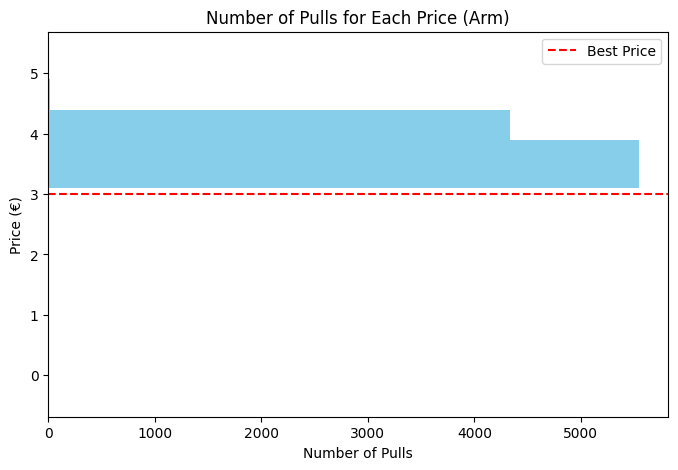

In [219]:
# --- Chosen arms on the alst trial ---
plt.figure(figsize=(8, 5))
plt.barh(P, ucb_like_agent.N_pulls, color='skyblue') 
plt.axhline(P[best_expected_index], color='red', linestyle='--', label='Best Price') 
plt.xlabel('Number of Pulls')
plt.ylabel('Price (€)')
plt.title('Number of Pulls for Each Price (Arm)')
_ = plt.legend()

### And the order they were chosen with.

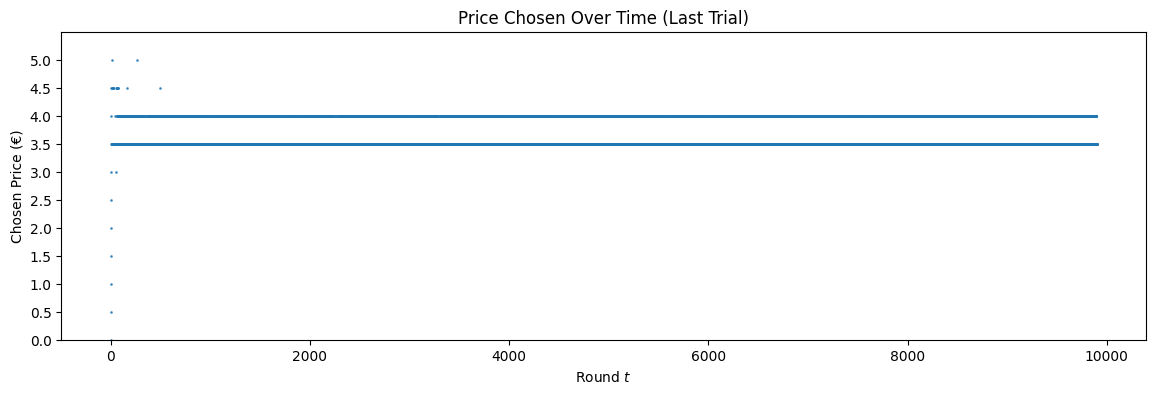

In [220]:
if 'actions_in_time' in locals() and actions_in_time:
    rounds_last = np.arange(len(actions_in_time))
else:
    rounds_last = np.array([])

fig, ax1 = plt.subplots(1, 1, figsize=(14, 4))

ax1.plot(rounds_last, actions_in_time, '.', markersize=2, alpha=0.7)
ax1.set_title("Price Chosen Over Time (Last Trial)")
ax1.set_xlabel("Round $t$")
ax1.set_ylabel("Chosen Price (€)")
ax1.set_yticks(np.arange(0, 5.5, 0.5))
ax1.set_ylim(0, max_p + price_step)
plt.show()

### Let's compare our algorithm against budget-constrained clairvoyants.

As we could see in the previous regret plot, it seems that the regret is not as good as we would expect, given the theoretical guarantees. The reason in this case is that we are comparing an algorithm playing with a very low budget - thus looking for a mix which lets it save items until the very latest rounds - against a clairvoyant which can keep selling as many items as wanted at each round. Thus, it's clear that the regret gets linear: the algorithm is literally learning how often to play the optimal move, playing a suboptimal one for the most times. In the following analysis we will see that even the best clairvoyant - which plays with a fixed arm, and not with a mixed policy - cannot beat our algorithm in the given setting. We also provide the comparison with a mixed strategy - properly said - clairvoyant.

In [229]:
# --- Clairvoyant fixed price under inventory constraint ---

expected_profits = []
expected_units = []

# Compute expected total profit for each price, under the inventory constraint B
for p, d in zip(P, expected_demand_vector):
    total_units = d * T                         # total units that could be sold at price p (if unlimited inventory)
    capped_units = min(total_units, B)          # actual units that can be sold given the inventory constraint
    profit = (p - cost) * capped_units          # expected total profit at this price
    expected_profits.append(profit)
    expected_units.append(capped_units)

expected_profits = np.array(expected_profits)
expected_units = np.array(expected_units)

# Select the best fixed price (clairvoyant choice under constraint)
best_index = np.argmax(expected_profits)
best_price = P[best_index]
best_profit = expected_profits[best_index]

# Print results for the fixed-price clairvoyant
print(f"--- Fixed Price Clairvoyant ---")
print(f"Best price: {best_price:.2f}")
print(f"Expected total profit: {best_profit:.2f}")

# Compute reward vector over T rounds for this fixed price
price_fixed = best_price
demand_fixed = expected_demand_vector[best_index]
reward_per_round_fixed = (price_fixed - cost) * demand_fixed

max_rounds_full = int(B // demand_fixed)  # how many full rounds can be executed
remaining_budget = B - (max_rounds_full * demand_fixed)
partial_reward = (price_fixed - cost) * remaining_budget if remaining_budget > 0 else 0

clairvoyant_rewards_fixed = np.zeros(T)
clairvoyant_rewards_fixed[:max_rounds_full] = reward_per_round_fixed
if max_rounds_full < T:
    clairvoyant_rewards_fixed[max_rounds_full] = partial_reward

# --- Clairvoyant mixed strategy under budget constraint ---

expected_rewards = (P - cost) * expected_demand_vector
expected_costs = expected_demand_vector
rho = B / T  # average budget per round

# Solve LP to find optimal randomized (mixed) pricing strategy under budget constraint
c = -expected_rewards        # we maximize reward → minimize negative reward
A_ub = [expected_costs]      # constraint: average cost per round <= rho
b_ub = [rho]
A_eq = [np.ones(K)]          # probabilities must sum to 1
b_eq = [1]

res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0, 1), method='highs')
gamma_star = res.x  # optimal mixed strategy
clairvoyant_mixed_reward_per_round = np.dot(gamma_star, expected_rewards)
clairvoyant_mixed_total_reward = clairvoyant_mixed_reward_per_round * T
clairvoyant_rewards_mixed = np.full(T, clairvoyant_mixed_reward_per_round)

# Print results for the mixed-strategy clairvoyant
print(f"\n--- Mixed Strategy Clairvoyant ---")
print(f"Best strategy: {np.round(gamma_star, 3)}")
print(f"Expected total reward: {clairvoyant_mixed_total_reward:.2f}")

--- Fixed Price Clairvoyant ---
Best price: 3.50
Expected total profit: 180000.00

--- Mixed Strategy Clairvoyant ---
Best strategy: [0.    0.    0.    0.    0.    0.    0.    0.543 0.457 0.    0.   ]
Expected total reward: 198137.30


### Visualize.

Suspicious results? ... Not really!

Final value of the regret vs fixed clairvoyant: -16439.749999998614
Final value of the regret vs mixed clairvoyant: 1697.5512583094417


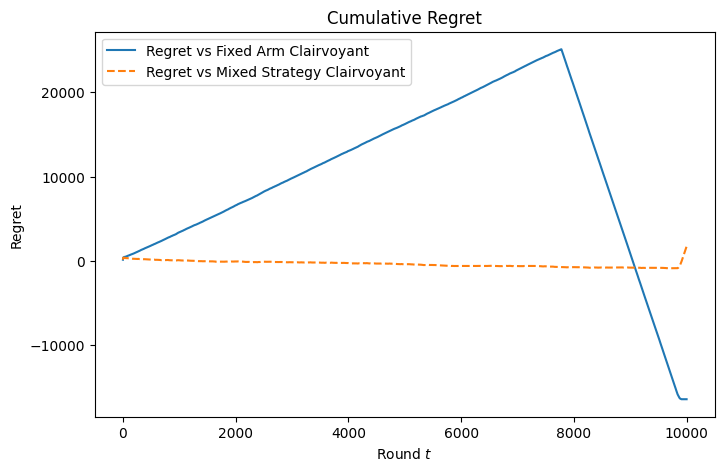

In [ ]:
# --- Run algorithm and compute regret against both baselines ---

regret_vs_fixed = []
regret_vs_mixed = []
inventory_trace_list = []

for seed in range(n_trials):
    np.random.seed(seed)    # Keep seed for reproducibility of each trial's sequence

    if seed == n_trials - 1:
        actions_in_time = []
        gamma_trace = []

    # Create environment
    env = PricingEnvironmentSingleProduct(cost=cost, mean_valuation=value, std_valuation=std_valuation, buyers_per_round=buyers_per_round)

    ucb_like_agent = UCBLikeInventoryAgent(K=K, B=B, T=T, range=1)
    rewards = []
    inventory_trace = []

    for t in range(T):
        if seed == n_trials - 1:
            action, gamma = ucb_like_agent.pull_arm(return_gamma=True)
        else:
            action = ucb_like_agent.pull_arm()

        if action is None:
            rewards.extend([0] * (T - t))
            inventory_trace.extend([ucb_like_agent.inventory] * (T - t))
            break

        if seed == n_trials - 1:
            actions_in_time.append(P[action])
            gamma_trace.append(gamma[best_index])

        price = P[action]
        demand, reward = env.round(price)
        ucb_like_agent.update(f_t=reward, c_t=demand)
        rewards.append(reward)
        inventory_trace.append(ucb_like_agent.inventory)

    rewards = np.array(rewards)
    regret_vs_fixed.append(np.cumsum(clairvoyant_rewards_fixed - rewards))
    regret_vs_mixed.append(np.cumsum(clairvoyant_rewards_mixed - rewards))
    inventory_trace_list.append(inventory_trace)

# --- Compute stats ---

avg_regret_fixed = np.mean(regret_vs_fixed, axis=0)
avg_regret_mixed = np.mean(regret_vs_mixed, axis=0)

avg_inventory_used = B - np.mean(inventory_trace_list, axis=0)

# --- Plots ---

plt.figure(figsize=(8, 5))

# Plot regret vs fixed clairvoyant
plt.plot(avg_regret_fixed, label='Regret vs Fixed Arm Clairvoyant')

# Plot regret vs mixed clairvoyant
plt.plot(avg_regret_mixed, label='Regret vs Mixed Strategy Clairvoyant', linestyle='--')

print("Final value of the regret vs fixed clairvoyant:", avg_regret_fixed[-1])
print("Final value of the regret vs mixed clairvoyant:", avg_regret_mixed[-1])

# Styling
plt.title("Cumulative Regret")
plt.xlabel("Round $t$")
plt.ylabel("Regret")
plt.legend()